<h2>Boosting</h2>

<b><i>Boosting</i></b> é uma abordagem utilizada para prover uma melhor performance para algoritmos clássicos de classificação e regressão. Apesar de poder ser aplicada sobre diversos algoritmos, a abordagem de <i>boosting</i> é comumente utilizada com algoritmos modelados no formato de árvore (árvores de decisão).

Em suma, a técnica de <b><i>boosting</i></b> consiste em um conjunto (<i>ensemble</i>) de algoritmos ditos fracos (com performance ligeiramente superior a 50%) que quando combinados, permitem por vezes performances superiores a um aloritmo dito "forte", como SVM ou RNA.

<h2>Algoritmo AdaBoost</h2>

O princípio por trás do <b>AdaBoost</b> é utilizar diversos algoritmos com poder de predição ligeiramente superior à uma escolha aleatória, executados repetidamente sobre o conjunto de dados. A cada iteração, cada instância recebe um peso de acordo com o resultado da predição anterior: o peso é incrementado caso o último algoritmo tenha classificado a instância incorretamente e decrementado caso contrário.

Portanto, as instâncias que foram anteriormente classificadas incorretamente recebem maior atenção quando o próximo algoritmo da iteração for executado. Ao final, o algoritmo soma as predições ponderadas de cada iteração, selecionado a classificação correta para as instâncias através de voto majoritário.

O algoritmo AdaBoost é apresentado a seguir:

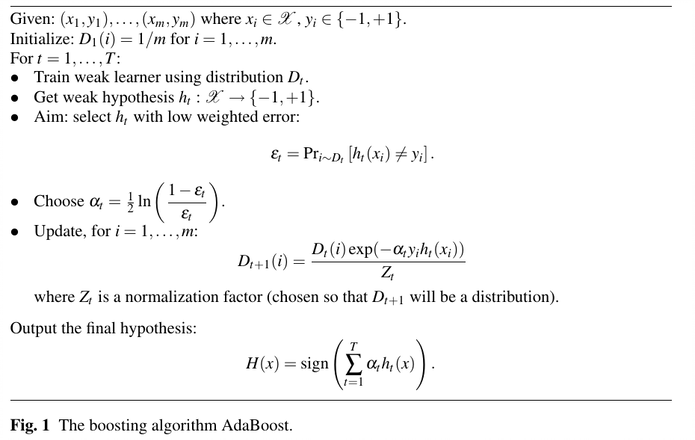

<h2>Implementação do AdaBoost em Python</h2>

Vamos implementar o algoritmo em uma classe a parte, permitindo uma melhor separação do código e posterior utilização do AdaBoost na fase de validação cruzada. Para isso, criamos uma classe nos moldes dos classificadores da biblioteca <b>SciKit Learn</b>, ou seja, com os métodos <b>fit</b> e <b>predict</b>.

In [1]:
import numpy as np

class Adaboost:
    
    def __init__(self, T):
        """
        Implementação de boosting para classificadores
        
        Parâmetros:
            
            T = Array de classificadores
        """
        self.T = T
        self.alphas = None
    
    def fit(self, X, y):
        """
        Treina os modelos
        
        Parâmetros:
            
            X = Dados de treino
            
            y = Labels de treino
            
        Retorno:
        
            predicted = Resultado da predição (y)
        """
        
        #inicializa os pesos
        weights = np.ones(len(X)) / float(len(X))
        
        i = 0
        
        alphas = []
        fit_predicted = np.zeros(len(y))
        
        #para cada classificador
        for clf in self.T:
            
            i += 1
            
            clf.fit(X, y, sample_weight=weights)
            
            predicted = clf.predict(X)
            
            miss = [int(d) for d in (predicted != y)]
            err   = np.dot(weights, miss)/np.sum(weights)
            alpha = 0.5 * np.log((1 - err)/err)
            
            #guarda o alpha para o classificador
            alphas.append(alpha)
            
            #ajusta os pesos
            weights = np.multiply(weights, np.exp([alpha * float(x) for x in miss]))/float(weights.sum())
            
            accuracy = sum([int(d) for d in (predicted == y)]) / len(predicted)
            
            fit_predicted = [sum(x) for x in zip(fit_predicted, [x * alpha for x in predicted])]
        
        self.alphas = alphas
        
        return np.sign(fit_predicted)
        
    def predict(self, X):#, y):
        """
        Faz a predição sobre um conjunto de dados
        
        Parâmetros:
        
            X = Dados a serem preditos
            
        Retorno:
        
            predicted = Resultado da predição (y)
        """
        predicted = np.zeros(len(X))
        
        for model, alpha in zip(self.T, self.alphas):
            
            pred = model.predict(X)
            
            #accuracy = sum([int(d) for d in (pred == y)]) / len(pred)
            
            #print(accuracy)
            
            predicted = [sum(x) for x in zip(predicted, [x * alpha for x in pred])]
            
        predicted = np.sign(predicted)
        
        return predicted

<h2>Explicando o algoritmo</h2>

Inicialmente a classe <b>Adaboost</b> deve ser inicializada com uma lista de algoritmos que serão utilizados durante o processo.

```
clfs =[]
clfs.append(DecisionTreeClassifier(criterion='entropy', max_depth=1))
clfs.append(DecisionTreeClassifier(criterion='entropy', max_depth=1))
clfs.append(DecisionTreeClassifier(criterion='entropy', max_depth=1))

model = Adaboost(clfs)
```

A quantidade de algoritmos presentes nessa lista é que irá determinar quantas vezes ocorrerá o processo <i>predição -> ajuste de peso</i>. No exemplo imediatamente anterior, são adicionados três classificadores do tipo Árvore de Decisão com profundidade 1, também conhecidas como Decision Stump. Isso significa que serão realizadas 3 iterações, com ajuste de peso das instâncias entre cada iteração.

```
#para cada classificador
for clf in self.T:
            
    clf.fit(X, y, sample_weight=weights)
            
    predicted = clf.predict(X)
            
    miss = [int(d) for d in (predicted != y)]
    err   = np.dot(weights, miss)/np.sum(weights)
    alpha = 0.5 * np.log((1 - err)/err)
            
    #ajusta os pesos
    weights = np.multiply(weights, np.exp([alpha * float(x) for x in miss]))/float(weights.sum())
            
    fit_predicted = [sum(x) for x in zip(fit_predicted, [x * alpha for x in predicted])]
```

De forma resumida, em cada iteração é realizado o processo de treinamento do modelo em questão. Após o treinamento, é calculado a taxa de erro (<i>err</i>) que é utilizada para calcular a taxa de atualização dos pesos (<i>alpha</i>).

Para instâncias preditas corretamente, o peso desta é decrementado com base no <i>alpha</i> calculado. O contrário ocorre com instâncias preditas incorretamente, as quais terão maior prioridade na próxima iteração.

Ao final, as predições geradas por todos os classificadores são somadas e a classe para cada instância é decidida pelo voto majoritário.

<h2>Utilizando o algoritmo AdaBoost</h2>

Para testar o algoritmo, utilizamos o <i>dataset</i> [sonnar.all.data](https://www.kaggle.com/ypzhangsam/sonaralldata) que possui dados de varreduras de sonares para identificação de minas.

É um problema de classificação binária, onde o objetivo é classificar cada instância como Rocha ou Mina.

In [2]:
import pandas as pd

df = pd.read_csv('sonar.all-data.csv', delimiter=',', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


Para facilitar o processo de aplicação do Adaboost, alteramos as classes das instâncias trocando-as:

Classe R -> -1
Classe M ->  1

In [3]:
df.iloc[:,-1] = [-1 if x == 'R' else 1 for x in df.iloc[:, -1]]

df.iloc[:,-1].unique()

array([-1,  1], dtype=int64)

Agora que o dataframe está carregado e com os labels ajustados, separamos 20% dos dados para teste e utilizamos 80% para treinamento:

In [4]:
from sklearn.model_selection  import train_test_split, StratifiedKFold

random_state = 1

train, test = train_test_split(df, test_size=0.2, stratify=df.iloc[:,-1], random_state=random_state)

<h2>Validação</h2>

Para validação de nosso algoritmo AdaBoost, vamos utilizar o método Cross Validation com 10-folds. Este método permite avaliar a capacidade de generalização de nosso modelo preditivo.

Também vamos iterar entre um intervalo para avaliar a performance de nosso algoritmo ao incrementarmos a quantidade de classificadores.

Para tal, usaremos como classificador uma Decision Stump.

In [5]:
from sklearn.tree             import DecisionTreeClassifier
from sklearn.metrics          import accuracy_score

n_folds = 10
n_clfs = 40

clfs = []

accuracy = []

max_idx_accur = 0

#armazena o melhor modelo do treinamento
best_model = None

for i in range(1,n_clfs + 1, 1):
    clfs.append(DecisionTreeClassifier(criterion='entropy', max_depth=1))

    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    boosting = Adaboost(clfs.copy())
    
    acc_cv = []
    
    #Cross-validation
    for train_idx, test_idx in kf.split(train, train.iloc[:, -1]):
        
        X_train, y_train = df.iloc[train_idx, :-1], df.iloc[train_idx, -1]
        X_test , y_test  = df.iloc[test_idx , :-1], df.iloc[test_idx, -1]
    
        pred = boosting.fit(X_train, y_train)
        
        pred_test = boosting.predict(X_test)
        
        acc_cv.append(accuracy_score(y_test, pred_test))
    
    if len(accuracy) == 0 or np.mean(acc_cv) > max(accuracy):
        max_idx_accur = i
        best_model = boosting
    
    accuracy.append(np.mean(acc_cv))

E como nosso modelo se saiu no treinamento?

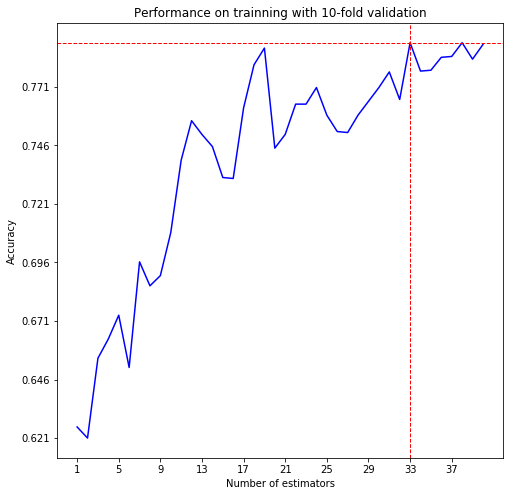

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(8, 8)) 
ax  = fig.add_subplot(111)

ax.set_title('Performance on trainning with 10-fold validation')
ax.plot(range(1, len(accuracy) + 1), accuracy, '-b')
ax.set_xlabel('Number of estimators')
ax.set_xticks(np.arange(1, len(accuracy) +1, len(accuracy) / 10))
ax.set_yticks(np.arange(min(accuracy), max(accuracy), 0.025))
ax.set_ylabel('Accuracy')
plt.axhline(max(accuracy), linestyle='--', color='red', linewidth=1)
plt.axvline(max_idx_accur, linestyle='--', color='red', linewidth=1)

Podemos verificar que há um acréscimo na performance conforme aumentamos a quantidade de Decision Stumps. O melhor modelo encontrado em um intervalo de 1 a 40 classificadores foi:

In [7]:
"Acurácia no treinamento {}, com {} classificadores.".format(max(accuracy), max_idx_accur)

'Acurácia no treinamento 0.7899754901960785, com 33 classificadores.'

<h2>Aplicando sobre os dados de teste</h2>

Agora vamos aplicar nosso melhor modelo (33 classificadores) sobre os dados de teste que separamos anteriormente (20% do dataset).

Mas antes vamos criar nossas próprias funções de cálculo de <i>recall</i>, <i>precision</i> e <i>f1-score</i>:

In [8]:
def calc_recall_score(true_y, pred_y, pos_label):
    tp = 0.
    fn = 0.
    
    for ty, py in zip(true_y, pred_y):
        if ty == pos_label and ty == py:
            tp += 1
        elif ty == pos_label and ty != py:
            fn += 1
            
    return tp / (tp + fn)
    
def calc_precision_score(true_y, pred_y, pos_label):
    tp = 0.
    fp = 0.
    
    for ty, py in zip(true_y, pred_y):
        if (ty == pos_label and ty == py):
            tp += 1
        elif (py == pos_label and ty != py):
            fp += 1
            
    return tp / (tp + fp)

def calc_f1_score(true_y, pred_y, pos_label):
    precision = calc_precision_score(true_y, pred_y, pos_label)
    recall = calc_recall_score(true_y, pred_y, pos_label)
    
    return 2* (precision*recall)/(precision+recall)

Agora sim...Vamos aplicar nosso modelo sobre os dados de teste:

In [9]:
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
predicted = boosting.predict(test_X)

accuracy_test = accuracy_score(test_y, predicted)

rM = calc_recall_score(test_y, predicted, pos_label=1)
rR = calc_recall_score(test_y, predicted, pos_label=-1)
pM = calc_precision_score(test_y, predicted, pos_label=1)
pR = calc_precision_score(test_y, predicted, pos_label=-1)

print('-------------------------------------------------')
print('Aplicando o melhor modelo sobre os dados de teste ')
print('-------------------------------------------------')
print('> Classificadores: ', len(best_model.T))
print('> Acurácia.......: ', accuracy_test)
print('-------------------------------------------------')
print('> Classe M (1): ')
print('\t> Recall: ', rM, ' / Precision: ', pM)
print('> Classe R (-1): ')
print('\t> Recall: ', rR, ' / Precision: ', pR)
print('-------------------------------------------------')
print('F1 Score: ', calc_f1_score(test_y, predicted, pos_label=1))

-------------------------------------------------
Aplicando o melhor modelo sobre os dados de teste 
-------------------------------------------------
> Classificadores:  33
> Acurácia.......:  0.8333333333333334
-------------------------------------------------
> Classe M (1): 
	> Recall:  0.7272727272727273  / Precision:  0.9411764705882353
> Classe R (-1): 
	> Recall:  0.95  / Precision:  0.76
-------------------------------------------------
F1 Score:  0.8205128205128205


<h2>Análise</h2>

Verificamos que nosso modelo obteve uma acurácia superior a encontrada durante o treinamento.

Entretanto, as diferenças entre Precision e Recall para a classe M preocupam. Pelo Recall em 0.72, podemos inferir que ocorreram muitos Falso Negativos, ou seja, muitas Minas foram classificadas como Rochas.

A métrica Precision para a classe R acaba confirmando a afirmação anterior: 76% indica que ocorreram muitos Falso Positivos, ou seja, muitas Minas que foram classificadas como Rochas.

Também trouxemos a métrica F1 Score, como forma de simplificar a avaliação do modelo. Com base nessa métrica, podemos verificar que, mesmo assim, obtemos um modelo razoável.

<h2>Comparando com outro modelo "sem boosting"</h2>

Para finalizar, vamos comparar nosso AdaBoost com um modelo sem utilização de <i>boosting</i>, no caso um SVM.

Para efeitos de comparação, manteremos a validação cruzada em 10-fols e a mesma amostra de treino e teste (80/20) utilizada no AdaBoost.

In [10]:
from sklearn.svm import SVC

model = SVC()

kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
#Cross-validation
for train_idx, test_idx in kf.split(train, train.iloc[:, -1]):

    X_train, y_train = df.iloc[train_idx, :-1], df.iloc[train_idx, -1]
    X_test , y_test  = df.iloc[test_idx , :-1], df.iloc[test_idx, -1]

    pred = model.fit(X_train, y_train)

    pred_test = model.predict(X_test)
    
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
predicted = model.predict(test_X)

accuracy_test = accuracy_score(test_y, predicted)

rM = calc_recall_score(test_y, predicted, pos_label=1)
rR = calc_recall_score(test_y, predicted, pos_label=-1)
pM = calc_precision_score(test_y, predicted, pos_label=1)
pR = calc_precision_score(test_y, predicted, pos_label=-1)

print('-------------------------------------------------')
print('       Aplicando SVM os dados de teste ')
print('-------------------------------------------------')
print('> Acurácia.......: ', accuracy_test)
print('-------------------------------------------------')
print('> Classe M (1): ')
print('\t> Recall: ', rM, ' / Precision: ', pM)
print('> Classe R (-1): ')
print('\t> Recall: ', rR, ' / Precision: ', pR)
print('-------------------------------------------------')
print('F1 Score: ', calc_f1_score(test_y, predicted, pos_label=1))

-------------------------------------------------
       Aplicando SVM os dados de teste 
-------------------------------------------------
> Acurácia.......:  0.5476190476190477
-------------------------------------------------
> Classe M (1): 
	> Recall:  0.13636363636363635  / Precision:  1.0
> Classe R (-1): 
	> Recall:  1.0  / Precision:  0.5128205128205128
-------------------------------------------------
F1 Score:  0.24000000000000002


<h2>Análise AdaBoost x SVM</h2>

Podemos verificar que o AdaBoost obteve valores de acurácia e F1-Score superiores ao SVM, quando na sua configuração default (C=1, gamma='auto').

Porém, quando ajustamos os parâmetros do SVM conseguimos obter uma performance ligeiramente superior ao AdaBoost:


In [11]:
model = SVC(C=50, gamma=0.1)

#Cross-validation
for train_idx, test_idx in kf.split(train, train.iloc[:, -1]):

    X_train, y_train = df.iloc[train_idx, :-1], df.iloc[train_idx, -1]
    X_test , y_test  = df.iloc[test_idx , :-1], df.iloc[test_idx, -1]

    pred = model.fit(X_train, y_train)

    pred_test = model.predict(X_test)
    
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
predicted = model.predict(test_X)

accuracy_test = accuracy_score(test_y, predicted)

rM = calc_recall_score(test_y, predicted, pos_label=1)
rR = calc_recall_score(test_y, predicted, pos_label=-1)
pM = calc_precision_score(test_y, predicted, pos_label=1)
pR = calc_precision_score(test_y, predicted, pos_label=-1)

print('-------------------------------------------------')
print('       Aplicando SVM os dados de teste ')
print('-------------------------------------------------')
print('> Acurácia.......: ', accuracy_test)
print('-------------------------------------------------')
print('> Classe M (1): ')
print('\t> Recall: ', rM, ' / Precision: ', pM)
print('> Classe R (-1): ')
print('\t> Recall: ', rR, ' / Precision: ', pR)
print('-------------------------------------------------')
print('F1 Score: ', calc_f1_score(test_y, predicted, pos_label=1))

-------------------------------------------------
       Aplicando SVM os dados de teste 
-------------------------------------------------
> Acurácia.......:  0.8571428571428571
-------------------------------------------------
> Classe M (1): 
	> Recall:  0.7272727272727273  / Precision:  1.0
> Classe R (-1): 
	> Recall:  1.0  / Precision:  0.7692307692307693
-------------------------------------------------
F1 Score:  0.8421052631578948
